In [1]:
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolo.utils import draw_outputs
from PIL import Image
from pandas import read_excel
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from data import generate_tfrecords as generate
from data import image_handler as ih
import numpy as np

In [2]:
locations = read_excel('/data2/seals/imgDirs/def/defImgDirs/PixelCoordinates_HgPupCounts2016_VersionToUse_20181017-1.xlsx', sheet_name="PixelCoordinates")

In [3]:
locations = locations[["tiff_file", "layer_name", "x_pixel", "y_pixel"]].dropna()
split = list(locations.groupby('tiff_file'))
file = split[2]
file

('StitchMICE_FoFcr16_4_1115_CP_FINAL.tif',
                                  tiff_file     layer_name  x_pixel  y_pixel
 20  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   2219.0   2127.0
 21  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   2095.0   2108.0
 22  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   1900.0   2078.0
 23  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   1693.0   2147.0
 24  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   1808.0   2484.0
 25  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   1398.0   1965.0
 26  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats   1624.0   2705.0
 27  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats    166.0   1458.0
 28  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats    877.0   1489.0
 29  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats    820.0   1303.0
 30  StitchMICE_FoFcr16_4_1115_CP_FINAL.tif  01 Whitecoats    903.0   1117.0
 31  StitchMICE_FoFcr16_4_1115_CP

In [4]:
img = mpimg.imread(f'/data2/seals/TIFFs/{file[0]}')
image = np.array(img)

(2087, 2167)
(2179, 2259)
(2068, 2148)
(2055, 2135)


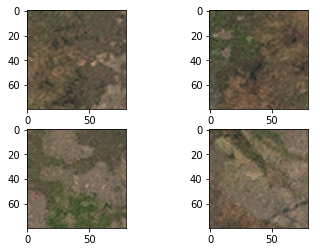

In [5]:
%matplotlib inline
# circles = [plt.Circle((row['x_pixel'], row['y_pixel']), 70, color='r', fc='none') for _, row in file[1].iterrows()]
fig, ax = plt.subplots(nrows=2, ncols=2)

# for circle in circles:
#     ax.add_artist(circle)
crops = [(row['x_pixel'], row['y_pixel']) for _, row in file[1].iterrows()][:4]
for i, (x, y) in enumerate(crops[:2]):
#     ax[0, i].imshow(img[y-40:y+40, x-40:x+40, :])
    y_min, y_max = (int(y-40), int(y+40))
    x_min, x_max = (int(x-40), int(x+40))
    print((y_min, y_max))
    print((x_min, x_max))
    ax[0, i].imshow(image[y_min:y_max, x_min:x_max, :])
for i, (x, y) in enumerate(crops[2:]):
    y_min, y_max = (int(y-40), int(y+40))
    x_min, x_max = (int(x-40), int(x+40))
    ax[1, i].imshow(image[y_min:y_max, x_min:x_max, :])
# for row in ax:
#     for col in row:
#         col.imshow
# ax.imshow(img)
# plt.savefig('/home/md273/out.png', dpi=1000)
# plt.show()

In [6]:
file[1].head()

,tiff_file,layer_name,x_pixel,y_pixel
20,StitchMICE_FoFcr16_4_1115_CP_FINAL.tif,01 Whitecoats,2219.0,2127.0
21,StitchMICE_FoFcr16_4_1115_CP_FINAL.tif,01 Whitecoats,2095.0,2108.0
22,StitchMICE_FoFcr16_4_1115_CP_FINAL.tif,01 Whitecoats,1900.0,2078.0
23,StitchMICE_FoFcr16_4_1115_CP_FINAL.tif,01 Whitecoats,1693.0,2147.0
24,StitchMICE_FoFcr16_4_1115_CP_FINAL.tif,01 Whitecoats,1808.0,2484.0


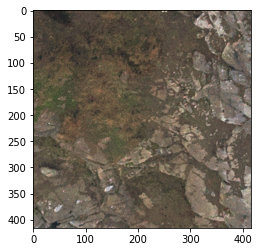

In [7]:
%matplotlib inline
with Image.open(f'/data2/seals/TIFFs/{file[0]}') as img:
    row = file[1].iloc[0]
    box = ih.get_bbox(
        (row["x_pixel"] - 416 / 2, row["x_pixel"] + 416 / 2), (row["y_pixel"] - 416 / 2, row["y_pixel"] + 416 / 2),
    )
    cropped = img.crop((box.x_min, box.y_min, box.x_max, box.y_max,))
    fig, ax = plt.subplots()
    ax.imshow(cropped)

## Visualising the generated toy dataset


In [8]:
import tensorflow as tf
from data import dataset

In [9]:
def parse_tfrecord(tfrecord, size):
    x = tf.io.parse_single_example(tfrecord, dataset.IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_png(x["image/encoded"], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    y_train = tf.stack(
        [
            tf.sparse.to_dense(x["image/object/bbox/xmin"]),
            tf.sparse.to_dense(x["image/object/bbox/ymin"]),
            tf.sparse.to_dense(x["image/object/bbox/xmax"]),
            tf.sparse.to_dense(x["image/object/bbox/ymax"]),
            tf.cast(tf.sparse.to_dense(x["image/object/class/label"]), tf.float32),
        ],
        axis=1,
    )

    paddings = [[0, 100 - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train


[0.4278846  0.4278846  0.57211536 0.57211536 0.        ]


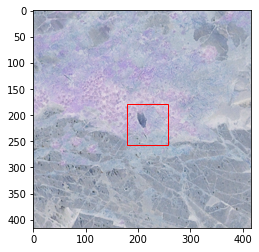

[0.4278846  0.4278846  0.57211536 0.57211536 0.        ]


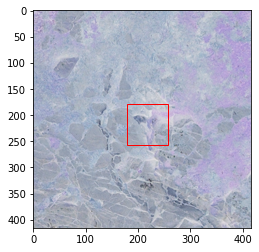

[0.4278846  0.4278846  0.57211536 0.57211536 0.        ]


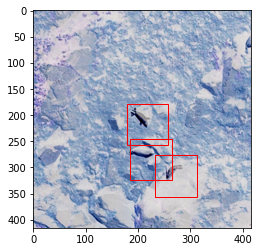

[0.4278846  0.4278846  0.57211536 0.57211536 0.        ]


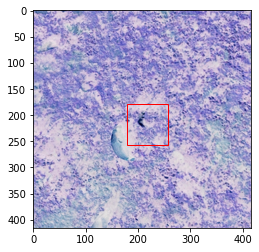

In [14]:
%matplotlib inline
train_dataset = tf.data.TFRecordDataset('/data2/seals/tfrecords/416_10/train.tfrecord')
train_dataset = train_dataset.map(lambda x: parse_tfrecord(x, 416))
ys = []
for x, y in train_dataset.take(4):
    ys += [y]
    _, ax  = plt.subplots()
    y = y.numpy()
    print(y[0])
    rectangles = [Rectangle(((row[0]* 416), (row[1] * 416)), 80, 80, color='r', fc='none') for row in y if row[0] != 0]
    for circle in rectangles:
        ax.add_patch(circle)
    ax.imshow((x.numpy()* 255).astype(np.uint8))
    plt.show()

In [15]:
ys

[array([[0.4278846 , 0.4278846 , 0.57211536, 0.57211536, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        ,